# Notebook 2.5.2: Student Plague (Implementation)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

## Implementing the Model

We  have
represented our SIR model not only as a set of differential equations but also as a stock-and-flow diagram.  But even if the differential equations and the diagram make intuitive sense, it's very difficult to understand the actual behavior of the system that is governed by those equations.  This is where computational tools are indispensible: we can represent our model a third way, by implementing it as a simulation.

### System and state objects

When we build a system object, we want to be able to enter the values that are easiest to think about.  For instance, in our baseball pitch simulation, it was easiest to think about about the speed of pitch in miles per hour, because that is the commonly used unit.  Then we used a small conversion function to convert that `mph` value to a `m/s` value.

<br>

The parameters that we enter will be integers: the population sizes, the recovery and the contact time.  Then when we make our system, we will translate those integers into the fractions `s`,`i`, `r`, `R`, and `C`, as those will be the values that we'll use in our code:

In [3]:
# Enter the parameters
iS = 89; iI = 1; iR = 0
time_c = 3; time_r = 4;
t_end = 14*7

# Make a system
N = iS + iI + iR
system = dict(iS=iS/N, iI=iI/N, iR=iR/N, N=N, C = 1/time_c,
              R = 1/time_r, t_end=t_end)

Our initial system has 90 students, one of whom is sick, and the simulation length is a 14 week semester.

<br>

In the coffee cooling problem our state variable was simply the temperature of the coffee.  But as with the bikeshare model, we have more to keep track of here, so we'll create a state object, too, which will include the state variables `s`, `i`, and `r`.  Recall that they represent the fraction of the population in each compartment, and so should sum to 1.0.

In [4]:
# The state object, populated with the initial state variables
import pandas as pd
state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),name="State Variables")

The state object will change as the system develops, but the system object will not.  And now that we have objects to represent the system and its state, we are ready for the change function.

### The Change Function

The purpose of an change function is to take the current state of a system and compute the state during the next time step.
In essense, we are *discretizing* our system of continuous differential equations into a discrete time step:

In [7]:
def change_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system['C'] * i * s
    recovered = system['R'] * i

    s -= infected
    i += infected - recovered
    r += recovered

    return pd.Series(dict(s=s, i=i, r=r),name="State")

`change_func` takes as parameters the current time, a state object, and a system object. The first line unpacks the state object, assigning the values of the state variables to new variables with the same names.  This is an example of *multiple assignment*.
The left side is a sequence of variables; the right side is a sequence of expressions.  The values on the right side are assigned to the variables on the left side, in order.

<br>

The change function computes `infected` and `recovered` as a fraction of the population, then updates `s`, `i` and `r`. The return value is a state that contains the updated values.  We can call `change_func` like this:

In [8]:
state = change_func(0, state, system)
state

s    0.985226
i    0.011996
r    0.002778
Name: State, dtype: float64

The result is the new state object.  You might notice that this version of `change_func` does not use one of its parameters, `t`. We include it anyway because change functions
sometimes depend on time, and it is convenient if they all take the same parameters, whether they need them or not.

---

<br>

🟨 🟨  Active Reading:  Multiple Choice

In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve

location = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/'
folder = 'Support_files/'
name = 'Embedded_Qs.ipynb'
local, _ = urlretrieve(location + folder + name, name)
%run /content/$name

#@title { run: "auto", form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data = display_multC('2_5_systems',home,6)
answer = "" # @param ["", "A", "B", "C", "D", "E"]
check_multC(data,answer)

---

### Running the Simulation

Now we can simulate the model over a sequence of time steps:

In [9]:
def run_simulation(system, change_func):
    state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),name="State Variables")

    for t in range(0, system['t_end']):
        state = change_func(t, state, system)

    return state

The parameters of `run_simulation` are the system object and the
change function. The system object contains the parameters, initial
conditions, and `t_end`.  We can call `run_simulation` like this:

In [10]:
final_state = run_simulation(system, change_func)
final_state

s    0.520568
i    0.000666
r    0.478766
Name: State, dtype: float64

The result indicates that after 14 weeks (98 days), about 52% of the
population is still susceptible, which means they were never infected,
almost 48% have recovered, which means they were infected at some point, and less than 1% are actively infected.

## Analyzing the Behavior of the System

The previous version of `run_simulation` only returns the final state,
but we might want to see how the state changes over time. We'll need to store all three state variables for each time step, so we'll need something other than a Series to do that.

### Storing and plotting multiple state variables

If the number of state variables is small, storing them as separate
Series objects might not be so bad. But a better alternative is to use a DataFrame, which can store more than one column of data.    A DataFrame, which is also in the Pandas library, is basically a spreadsheet.  We'll set it up like this:

<br>

<center>
<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/2_5/dataframe.PNG width = 400>
</center>

<br>

Look at the comments in `run_simulation` below to see how we do this:

In [12]:
def run_simulation(system, change_func):
    # Create the state object
    state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),
                      name="State Variables")

    # Create the empty dataframe with s, i, and r as its columns
    frame = pd.DataFrame([],columns=state.index)

    # Add initial state to the dataframe
    # At this point, the dataframe looks like the image above
    frame.loc[0] = state

    # Loop through the time steps and add data to the dataframe
    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)

    return frame

Based on the way we've been using
Series objects, it is tempting in line 11 to write

```
frame[0] = state
```

But when you use the bracket operator with a `DataFrame`, it selects a column, not a row.
To select a row, we have to use `loc`, like this:

```
frame.loc[0] = state
```

Since the value on the right side is a `Series`, the assignment matches
up the index of the `Series` with the columns of the `DataFrame`; that
is, it assigns the `s` value from `state` to the `s` column of
`frame`, and likewise with `i` and `r`.

<br>

Each time through the loop, we assign the state object we get from `change_func` to the next row of `frame`, thus building step-by-step a 3-column spreadsheet of values.
At the end, we return the spreadsheet (i.e. the DataFrame):

In [13]:
results = run_simulation(system, change_func)
results.head()

,s,i,r
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


The columns in the DataFrame correspond to the state variables, `s`, `i`, and `r`.
We can use the dot operator to select columns
from a DataFrame.  Because each column of the DataFrame is a Series, we can plot the columns with the `plot()` function:

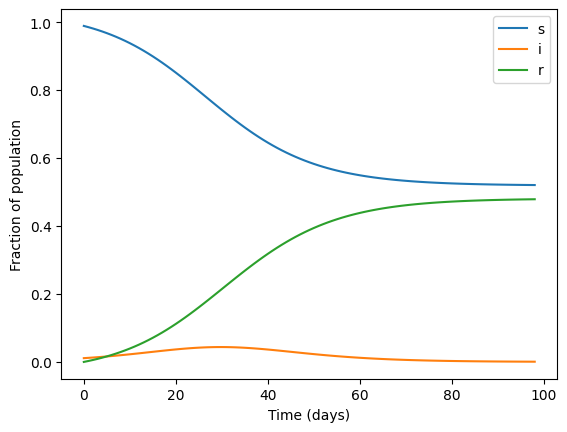

In [17]:
# This line says "plot column 's' of Dataframe 'results'"
results.s.plot(xlabel = 'Time (days)', ylabel = 'Fraction of population',
               legend = True)
results.i.plot(legend = True)
results.r.plot(legend = True);

## Exercises


---

<br>

🟨 🟨  

### Exercise 1  

Suppose the time between contacts is 4 days and the recovery time is 5 days.  After 14 weeks, how many students, total, have been infected?

In [ ]:
# Create initial state and system



In [ ]:
# Use run_simulation and plot_results to display the behavior of the system


✅ ✅ Note the total number of students infected here.

---

<br>

🟨 🟨  

### Exercise 2

Describe the effect of the change on the behavior of the system.  Do more people get sick?  Why?  Explain in terms of the parameters `R` and `C`.

✅ ✅ Put answer here

---

<br>

🟨 🟨  

### Exercise 3

✅ Play with the model by manipulating the parameters.  What combination of `C` and `R` produces the highest levels of infection at a given time?  What combination produces late and early peaks of the epidemic?   Does changing the overall population (increase `iS` while leaving `iI` and `iR` the same) create large changes in the behavior of the epidemic?

✅ ✅ Discuss your results here.